# Notebook KNN7:  Ein KNN lernt, Pong zu spielen (Reinforcement learning).

Machen Sie sich mit dem Spiel Pong vertraut, z.B. hier https://de.pong-2.com.


Wir trainieren ein KNN mittels Reinforcement learning (verstärkendes Lernen) um Pong zu spielen. Dabei verwenden wir das Interface von "OpenAI Gym", https://gym.openai.com/.


Der Code basiert auf http://karpathy.github.io/2016/05/31/rl/, 
 https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5 und https://github.com/mrahtz/tensorflow-rl-pong/blob/master/pong.py.

# Pakete und Hilfsfunktionen laden

In [0]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1


In [0]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
#  mp4list = glob.glob('./content/drive/My Drive/video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
 # env = Monitor(env, './content/drive/My Drive/video', force=True)

    return env

## function used to preprocess the image
def Bild_Transformation_Visuell(I):
    I = I[35:195]  # crop
    I = I[:, :, 0]  # downsample by factor of 2, remove the second and third RGB value
    I[I == 144] = 0  # erase background (background type 1)
    I[I == 109] = 0  # erase background (background type 2)
    I[I != 0] = 100  # everything else (paddles, ball) just set to 1. For this visualization we use 100. 
    I = skimage.measure.block_reduce(I, (2,2), np.max) # max pooling
    I = I[::2, ::2]  # downsample by factor of 2, remove the second and third RGB value
    return I

# Input-Bilder

In jedem Schritt des Spiels gibt es nur drei Aktionen: Schläger nach unten, Schläger nach oben, oder Schläger nicht bewegen. Führen Sie den folgenden Code aus. Sie sehen zwei aufeinanderfolgende Bilder während eines Pong-Spiels:

Bild 1:



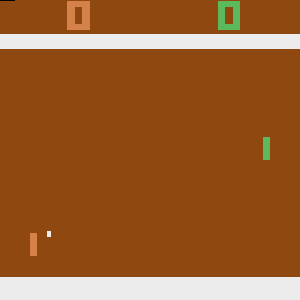



Bild 2:



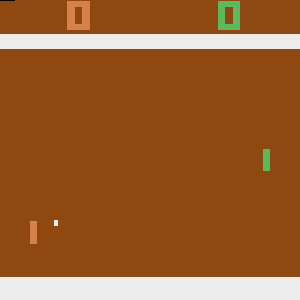

In [26]:
import imageio
from IPython.display import Image, display


import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import IPython
import skimage.measure

from PIL import Image
import skimage.measure

env = gym.make('Pong-v0')

env.reset()

AKTION_OBEN = 2
AKTION_UNTEN = 3
AKTION_NICHTS = 0 
# env.step(0): Keine Aktion
# env.step(2): Schläger nach oben
# env.step(3): Schläger nach unten

# 40 mal keine Aktion ausführen und warten bis der Ball im Spielfeld ist.
for j in range(40):
    o,_,_,_ = env.step(0)

Bild1,_,_,_ = env.step(0) # keine Aktion ausführen
Bild2,_,_,_ = env.step(3) # Schläger nach unten bewegen

print('Bild 1:\n')
IPython.display.display(
        Image.fromarray(
            Bild1
       ).resize((300, 300))
    )
print('\n')

print('Bild 2:\n')
IPython.display.display(
        Image.fromarray(
            Bild2
       ).resize((300, 300))
    )

env.close()



Der Input für unser neuronales Netz ist die Differenz zweier aufeinanderfolgender Bilder, welche noch vergrößert, am oberen Rand abgeschnitten und in Grauwerte umgewandelt wird. Dies ergibt 40x40-Pixel-Bilder. 

Differenz zweier Bilder (ohne Spielstand und vergrößert):



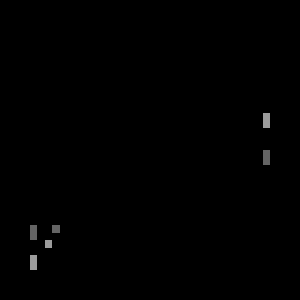

In [27]:
Bild_Differenz = Bild_Transformation_Visuell(Bild2) - Bild_Transformation_Visuell(Bild1)


print('Differenz zweier Bilder (ohne Spielstand und vergrößert):\n')
IPython.display.display(
        Image.fromarray(
            Bild_Differenz
       ).resize((300, 300))
    )

# Beispiel: 

Wir spielen mit zufälligen Aktionen, bis eine 'epsiode' vorbei ist (bis episode_done==True), d.h. bis ein Spieler 21 Punkte gewonnen hat.

In [0]:
env = wrap_env(gym.make("Pong-v0"))

observation = env.reset()

while True:
  
    env.render()
    
    #we use a random action
    action = env.action_space.sample() 
         
    observation, reward, episode_done, info = env.step(action)   
        
    if episode_done == True: 
      break;
            
env.close()
show_video()

# Ein KNN trainieren

Unser KNN soll ein Bild der Form "Bild_Differenz" als Input bekommen und dann entscheiden, ob der Schläger nach oben oder unten geführt wird. (Die Option "Schläger nicht bewegen" wird im Folgenden ignoriert. Der Schläger wird sich also in jedem Schritt bewegen.)

Wir definieren ein KNN, mit 1600 Input-Neuronen (40x40=1600) und einem Output-Neuron mit sigmoid-Funktion. Der Ausgabewert liegt damit stets zwischen 0 und 1 und wird als Wahrscheinlichkeit interpretiert, den Schläger nach oben zu bewegen. 

In [62]:
# Modell definieren
model = Sequential()
#tf.keras.initializers.glorot_normal()
model.add(Dense(units=200, activation='relu', use_bias=True, kernel_initializer = keras.initializers.Zeros(), input_shape=(1600,))) # 40*40 = 1600 Pixel
model.add(Dropout(0.2))
#model.add(Dense(units=30, use_bias=True, kernel_initializer = tf.keras.initializers.random_normal(mean = 0, stddev = 0.1), activation='relu'))
model.add(Dense(units=520, use_bias=True, kernel_initializer = keras.initializers.Zeros(), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, use_bias=True, kernel_initializer = keras.initializers.Zeros(), activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               320200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 520)               104520    
_________________________________________________________________
dropout_4 (Dropout)          (None, 520)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 521       
Total params: 425,241
Trainable params: 425,241
Non-trainable params: 0
_________________________________________________________________


Alternativ: Modell aus den Dateien 'model_pong.json' und 'model_pong_weights.h5' laden:

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!cp '/content/drive/My Drive/Checkpoints/model_pong.json' 'model_pong.json' 
!cp '/content/drive/My Drive/Checkpoints/model_pong_weights.h5' 'model_pong_weights.h5' 

# Alternaiv: Modell laden
from keras.models import model_from_json

json_file = open('model_pong.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("model_pong_weights.h5")

model.summary()

Als Beispiel betrachten wir die Ausgabe für Bild_Differenz:

In [30]:
output = model.predict(Bild_Differenz.reshape([-1,1600]))[0]

print("Output: " + str(output[0]))

print("Wahrscheinlichkeit für \"Schläger nach oben\": " + str(output[0]*100) + " %")
print("Wahrscheinlichkeit für \"Schläger nach unten\": " + str((1-output[0])*100) + " %")

Output: 0.29197988
Wahrscheinlichkeit für "Schläger nach oben": 29.197987914085388 %
Wahrscheinlichkeit für "Schläger nach unten": 70.80201208591461 %


Wir trainieren nun unser Modell:

In [0]:
import IPython
from PIL import Image


import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import skimage.measure

from __future__ import print_function
import os.path
import numpy as np
import tensorflow as tf
import pickle


#Parameter
learning_rate = 0.0001
end_count=2000 # Anzahl der Matches insgesamt
checkpoint_every_n_episodes = 500
last_pictures = []
load_checkpoint = True
batch_size = 8 

env = wrap_env(gym.make("Pong-v0"))


batch_states = []
batch_actions = []
batch_rewards = []

episode_n = 1
action_dict = {AKTION_UNTEN: 0, AKTION_OBEN: 1}


from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
    #    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        
        return tf.losses.log_loss(labels=y_true, predictions=y_pred, weights= np.reshape(weights,[-1,1]))

      
    return loss

def Bild_Transformation(I):
    I = I[35:195]  # crop
    I = I[:, :, 0]  # downsample by factor of 2, remove the second and third RGB value
    I[I == 144] = 0  # erase background (background type 1)
    I[I == 109] = 0  # erase background (background type 2)
    I[I != 0] = 1  # everything else (paddles, ball) just set to 1. For this visualization we use 100. 
    I = skimage.measure.block_reduce(I, (2,2), np.max) # max pooling
    I = I[::2, ::2]  # downsample by factor of 2, remove the second and third RGB value
    return I
  
wins = 0
losses = 0
win_max = 0
bestes_Spiel = []
  
while True:
    env = wrap_env(gym.make("Pong-v0"))
    print("Starting episode %d" % episode_n)
      
    episode_done = False
    episode_reward_sum = 0

    round_n = 0

    last_observation = env.reset()
    last_observation = Bild_Transformation(last_observation)
    action = env.action_space.sample()
    observation, _, _, _ = env.step(action)
    observation = Bild_Transformation(observation)
    n_steps = 1

    batch_states2 = []
    batch_actions2 = []
    batch_rewards2 = []
    
    last_pictures = []
    
    while True:
        if episode_n == end_count:
            env.render()



        observation_delta = observation - last_observation
        last_observation = observation

        up_probability = model.predict(observation_delta.reshape([-1,1600]))[0]
        if np.random.uniform() < up_probability:
            action = AKTION_OBEN
        else:
            action = AKTION_UNTEN

        observation, reward, episode_done, info = env.step(action)
       # if episode_n == end_count:
        if True:
            last_pictures.append(observation)
        observation = Bild_Transformation(observation)
        episode_reward_sum += reward
        n_steps += 1

        batch_states.append(observation_delta)
        batch_actions.append(action_dict[action])
        batch_rewards.append(reward)
        


      #  if reward == -1:
      #      print("Round %d: %d time steps; lost..." % (round_n, n_steps))
      #  elif reward == +1:
       #     print("Round %d: %d time steps; won!" % (round_n, n_steps))
        if reward == +1:
          #  print("Round %d: %d time steps; won!" % (round_n, n_steps))
            wins += 1
        if reward == -1: 
            losses += 1

        if reward != 0:
            round_n += 1
            n_steps = 0
        if episode_done == True:
            #if len(last_pictures) > 0:
             #   show_video()
            break
        

    print("Episode %d finished after %d rounds. Wins: %d, losses: %d" % (episode_n, round_n, wins, losses))
    
    if wins > win_max:
        win_max = wins
        bestes_Spiel = last_pictures
        print("Neues bestes Spiel mit " + str(win_max) + " Gewinnen!")
        
    
    
    wins = 0
    losses = 0
    last_pictures = []
    
    
    if episode_n % batch_size == 0:
        
       
        batch_rewards  -= np.mean(batch_rewards)
        batch_rewards /= np.std(batch_rewards)

        batch_states = np.array(batch_states)       
        batch_actions = np.array(batch_actions)
        batch_rewards = np.array(batch_rewards)
     #   batch_rewards += np.min(batch_rewards)
      
       # model.compile(optimizer=keras.optimizers.SGD(lr=Lernrate), loss='categorical_crossentropy', metrics=['accuracy'])
       # model.fit(batch_states, y_train_hot, batch_size=batch_size, epochs=Anzahl_Iterationen, verbose=False,  validation_data=(x_test.reshape(len(x_test),784), y_test_hot))
        loss = weighted_categorical_crossentropy(batch_rewards)
        model.compile(loss=loss,optimizer=keras.optimizers.Adam(lr=learning_rate))
       # model.compile(loss='binary_crossentropy',optimizer='adam')
        print("Training...")
        model.fit(batch_states.reshape([-1,1600]), batch_actions, batch_size=len(batch_states), epochs=1, verbose=False)
       # network.train(batch_states, batch_actions, batch_rewards)
            
        batch_states = []
        batch_actions = []
        batch_rewards = []
    
    if episode_n % checkpoint_every_n_episodes == 0:
        model_json = model.to_json()
        with open("model_pong.json", "w") as json_file:
            json_file.write(model_json)
        model.save_weights("model_pong_weights.h5")
  
    
    if episode_n ==end_count:
      break
      
    episode_n += 1
    
env.close()
show_video()

# Modell speichern

Wir speichern unser trainiertes Modell in den zwei Dateien 'model_pong.json' und 'model_pong_weights.h5'.

In [0]:
model_json = model.to_json()
with open("model_pong.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_pong_weights.h5")

!cp 'model_pong.json' '/content/drive/My Drive/Checkpoints/model_pong.json'
!cp 'model_pong_weights.h5' '/content/drive/My Drive/Checkpoints/model_pong_weights.h5'

# Gif Datei erstellen

Wir erstellen eine GIF-Datei aus unserem besten Spiel, "bestes_Spiel". Da diese Datei sehr groß ist, erstellen wir noch eine GIF-Datei mit kleinerer Auflösung.

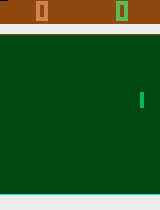

In [85]:
import imageio
from IPython.display import Image, display

bestes_Spiel_klein= []

for j in range(len(bestes_Spiel)):
    I = bestes_Spiel[j]
    I = I[::2,::2,:]
    bestes_Spiel_klein.append(I)

imageio.mimsave('bestes_Spiel.gif', bestes_Spiel, duration = 0.04)
imageio.mimsave('bestes_Spiel_klein.gif', bestes_Spiel_klein, duration = 0.04)

# Dateien in google Drive kopieren.
!cp 'bestes_Spiel_klein.gif' '/content/drive/My Drive/bestes_Spiel_klein.gif'
!cp 'bestes_Spiel.gif' '/content/drive/My Drive/bestes_Spiel.gif'


with open('bestes_Spiel.gif','rb') as f:
    display(Image(data=f.read(), format='png', width=160, height=210)) #  width=160, height=210